In [1]:
# %matplotlib notebook 

In [1]:
!pip install seaborn

In [2]:
import os
import numpy as np
import math
from tqdm import tqdm
import wandb
import pickle
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open(f"/ssd_scratch/users/sriram.devata/model_mae_errors_compare_predictions.pkl", "rb") as input_file:
    model_maes, all_model_maes, model_angle_errors_to_export = pickle.load(input_file)
with open(f"/ssd_scratch/users/sriram.devata/spot_rna_mae_errors_compare_predictions.pkl", "rb") as input_file:
    spot_maes, all_spot_maes, spot_angle_errors_to_export = pickle.load(input_file)
with open(f"/ssd_scratch/users/sriram.devata/random_baseline_mae_errors_compare_predictions.pkl", "rb") as input_file:
    random_maes, all_random_maes, random_angle_errors_to_export = pickle.load(input_file)

In [4]:
print(len(all_model_maes[0]))
print(len(model_angle_errors_to_export[0][0]))

all_dihedral_angle_names = ["alpha" ,"beta" ,"gamma" ,"delta" ,"chi" ,"epsilon" ,"zeta" ,"eta" ,"theta"]


8182
70


In [8]:
all_dihedral_angle_names = ["alpha ($\\alpha$)" ,"beta ($\\beta$)" ,"gamma ($\\gamma$)" ,"delta ($\\delta$)" ,"chi ($\\chi$)" ,"epsilon ($\\epsilon$)" ,"zeta ($\\zeta$)" ,"eta ($\\eta$)" ,"theta ($\\theta$)"]


green_diamond = dict(markerfacecolor='g', marker='D')
data = pd.DataFrame(columns=["Dihedral angle", "TorRNA", "SPOT-RNA-1D", "Random Baseline"])

df_loc = 0
for each_dihedral_angle_idx in range(len(all_model_maes)):
    print(f"Dihedral angle: {each_dihedral_angle_idx}")
#     data.append(all_model_maes[each_dihedral_angle_idx])
#     data.append(all_spot_maes[each_dihedral_angle_idx])
#     data.append(all_random_maes[each_dihedral_angle_idx])
        
    for each_error_idx in tqdm(range(len(all_model_maes[each_dihedral_angle_idx]))):
        data.loc[df_loc] = [all_dihedral_angle_names[each_dihedral_angle_idx],
                          all_model_maes[each_dihedral_angle_idx][each_error_idx],
                         all_spot_maes[each_dihedral_angle_idx][each_error_idx],
                         all_random_maes[each_dihedral_angle_idx][each_error_idx]]
        df_loc += 1

Dihedral angle: 0


100%|██████████| 8182/8182 [00:07<00:00, 1033.18it/s]


Dihedral angle: 1


100%|██████████| 8255/8255 [00:10<00:00, 813.09it/s]


Dihedral angle: 2


100%|██████████| 8265/8265 [00:12<00:00, 653.25it/s]


Dihedral angle: 3


100%|██████████| 8265/8265 [00:15<00:00, 545.86it/s]


Dihedral angle: 4


100%|██████████| 8266/8266 [00:17<00:00, 482.28it/s]


Dihedral angle: 5


100%|██████████| 8010/8010 [00:18<00:00, 432.09it/s]


Dihedral angle: 6


100%|██████████| 8010/8010 [00:20<00:00, 382.35it/s]


Dihedral angle: 7


100%|██████████| 7935/7935 [00:22<00:00, 351.17it/s]


Dihedral angle: 8


100%|██████████| 8004/8004 [00:24<00:00, 321.71it/s]


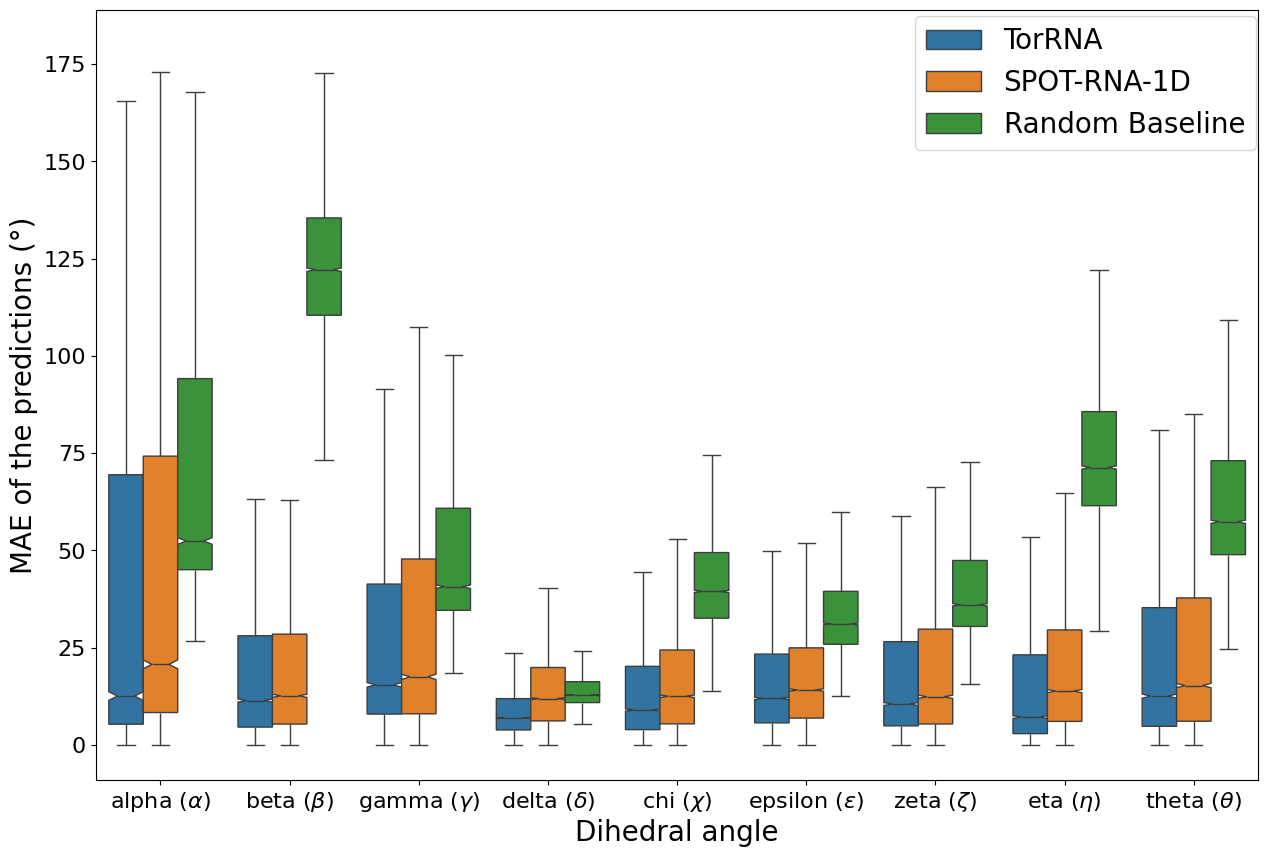

In [9]:
fig, axs = plt.subplots(1,1, figsize=(15, 10))
plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)


dd = pd.melt(data,id_vars=['Dihedral angle'],value_vars=["TorRNA", "SPOT-RNA-1D", "Random Baseline"],var_name='Prediction Method')
sns.boxplot(x='Dihedral angle',y='value',data=dd,hue='Prediction Method',
           notch=True, fliersize=0)

axs.set_ylabel("MAE of the predictions (°)")
# plt.title("Distribution of the MAEs of the predicted (pseudo)torsion angles")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(1.01, 1.01), loc='upper right')
plt.savefig('images/boxplot_maes.svg', dpi=300)
plt.show()

In [10]:
buckets_freq = 30

all_rna_lengths = list()
for each_rna_idx in range(len(model_angle_errors_to_export[0])): # For the first angle
    all_rna_lengths.append(len(model_angle_errors_to_export[0][each_rna_idx]))
all_rna_lengths = sorted(all_rna_lengths)
    
all_buckets = list()
cur_length = all_rna_lengths[0]
prev_length = cur_length
bucket_start_length = cur_length
cur_bucket_size = 0
for each_rna_length in all_rna_lengths:
    if prev_length != each_rna_length:
        prev_length = cur_length
        if cur_bucket_size > buckets_freq:
            all_buckets.append((bucket_start_length, prev_length, cur_bucket_size))
            bucket_start_length = cur_length
            cur_bucket_size = 0
        
    cur_length = each_rna_length
    cur_bucket_size += 1
all_buckets.append((bucket_start_length, cur_length, cur_bucket_size))

print(all_buckets)
all_buckets_maes = [[list() for _ in all_dihedral_angle_names] for _ in all_buckets]

for bucket_idx, (each_bucket_start, each_bucket_end, _) in enumerate(all_buckets):
    print(f"\nBucket length range: {each_bucket_start}-{each_bucket_end}")
    for each_angle_idx in range(len(all_dihedral_angle_names)):
            total_errors = 0
            total_num_errors = 0

            for each_rna_idx in range(len(model_angle_errors_to_export[each_angle_idx])):
                len_rna = len(model_angle_errors_to_export[each_angle_idx][each_rna_idx])
                if len_rna >= each_bucket_start and len_rna <= each_bucket_end:
                    total_errors += sum(model_angle_errors_to_export[each_angle_idx][each_rna_idx])
                    total_num_errors += len_rna
            # mae = sum(model_angle_errors_to_export[each_angle_idx][:])/len(model_angle_errors_to_export[each_angle_idx][:])

            mae = total_errors/total_num_errors
            all_buckets_maes[bucket_idx][each_angle_idx] = mae
            print(f"{all_dihedral_angle_names[each_angle_idx]}: {mae:.3f}", end=', ')

print(all_buckets_maes)

[(16, 25, 32), (25, 33, 32), (33, 44, 31), (44, 59, 34), (59, 92, 31), (92, 148, 12)]

Bucket length range: 16-25
alpha ($\alpha$): 43.832, beta ($\beta$): 22.240, gamma ($\gamma$): 39.559, delta ($\delta$): 16.163, chi ($\chi$): 20.779, epsilon ($\epsilon$): 22.719, zeta ($\zeta$): 31.272, eta ($\eta$): 25.724, theta ($\theta$): 28.684, 
Bucket length range: 25-33
alpha ($\alpha$): 42.350, beta ($\beta$): 22.032, gamma ($\gamma$): 38.628, delta ($\delta$): 16.847, chi ($\chi$): 23.163, epsilon ($\epsilon$): 20.719, zeta ($\zeta$): 35.001, eta ($\eta$): 25.984, theta ($\theta$): 32.743, 
Bucket length range: 33-44
alpha ($\alpha$): 42.068, beta ($\beta$): 20.531, gamma ($\gamma$): 38.783, delta ($\delta$): 17.047, chi ($\chi$): 24.513, epsilon ($\epsilon$): 20.014, zeta ($\zeta$): 28.719, eta ($\eta$): 25.812, theta ($\theta$): 29.996, 
Bucket length range: 44-59
alpha ($\alpha$): 42.954, beta ($\beta$): 20.846, gamma ($\gamma$): 35.914, delta ($\delta$): 14.269, chi ($\chi$): 19.134, 

In [11]:
all_dihedral_angle_names = ["alpha ($\\alpha$)" ,"beta ($\\beta$)" ,"gamma ($\\gamma$)" ,"delta ($\\delta$)" ,"chi ($\\chi$)" ,"epsilon ($\\epsilon$)" ,"zeta ($\\zeta$)" ,"eta ($\\eta$)" ,"theta ($\\theta$)"]

data = pd.DataFrame(columns=["Bucket", "Angle", "MAE"])

df_loc = 0
for each_dihedral_angle_idx in range(len(all_model_maes)):
    for each_bucket_idx, each_bucket in enumerate(all_buckets):        
        data.loc[df_loc] = [f"{each_bucket[0]}-{each_bucket[1]}\n({each_bucket[2]})", all_dihedral_angle_names[each_dihedral_angle_idx], all_buckets_maes[each_bucket_idx][each_dihedral_angle_idx]]
        df_loc += 1

data

,Bucket,Angle,MAE
0,16-25\n(32),alpha ($\alpha$),43.832224
1,25-33\n(32),alpha ($\alpha$),42.350481
2,33-44\n(31),alpha ($\alpha$),42.068203
3,44-59\n(34),alpha ($\alpha$),42.954473
4,59-92\n(31),alpha ($\alpha$),40.634223
5,92-148\n(12),alpha ($\alpha$),43.757512
6,16-25\n(32),beta ($\beta$),22.240430
7,25-33\n(32),beta ($\beta$),22.032364
8,33-44\n(31),beta ($\beta$),20.531193
9,44-59\n(34),beta ($\beta$),20.846236


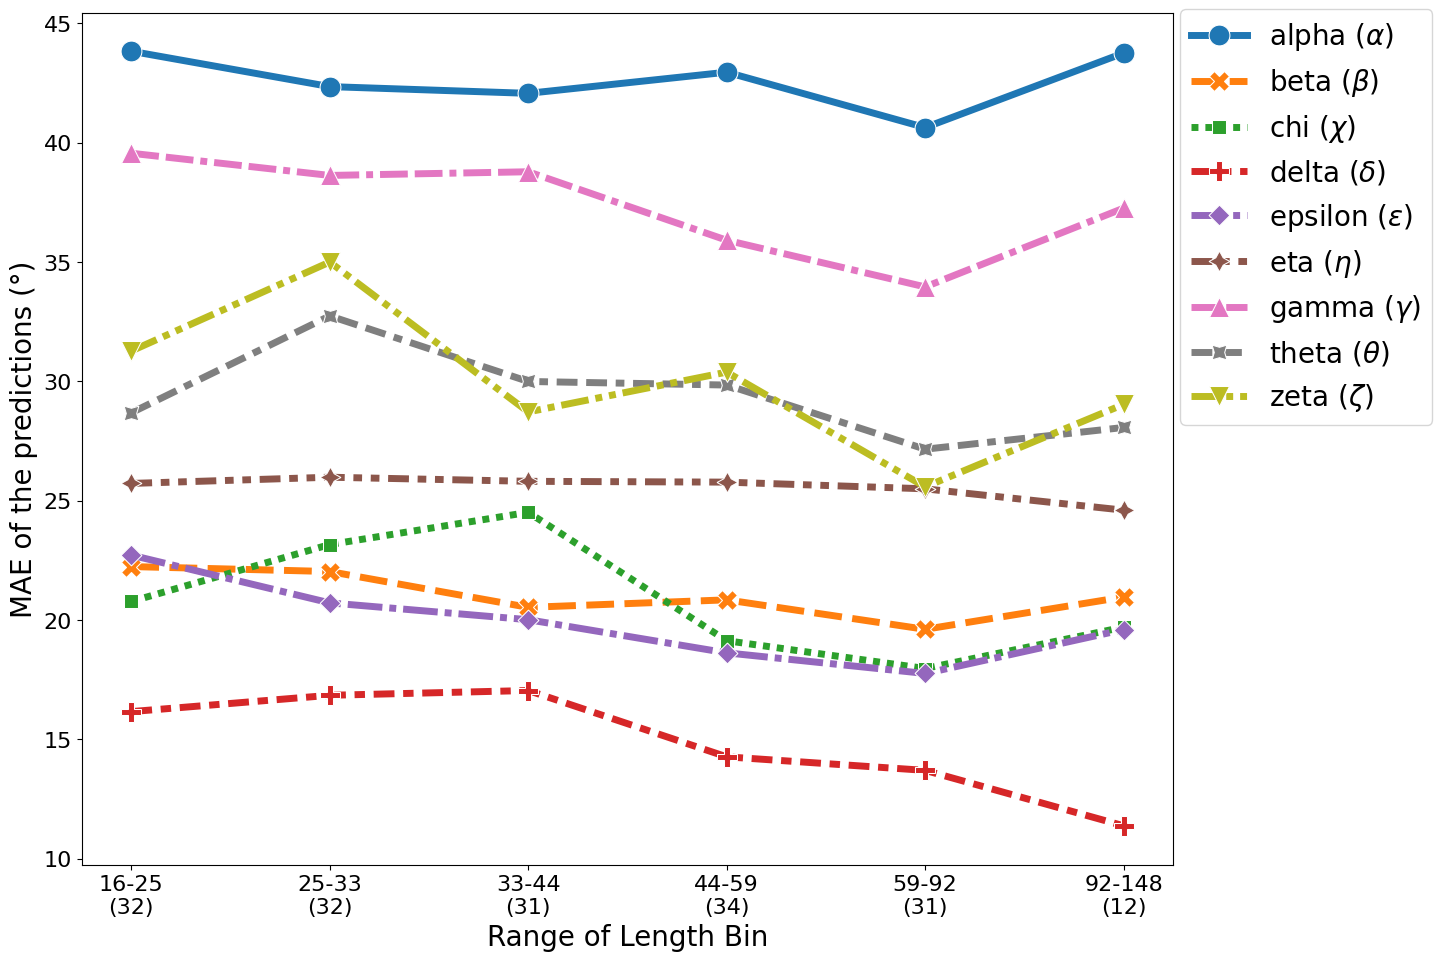

In [15]:
fig, axs = plt.subplots(1,1, figsize=(15, 10))

data_wide = data.pivot(index="Bucket", columns="Angle", values="MAE")
data_wide.head()
sns.lineplot(data=data_wide, markers=True, dashes=True, linewidth=5, markersize=15)

axs.set_ylabel("MAE of the predictions (°)")
axs.set_xlabel("Range of Length Bin")#\n(Frequency of each length bin)")

# plt.title("MAEs of the (pseudo)torsion angles for various RNA sequence lengths")
plt.legend(bbox_to_anchor=(1.25, 1.02), loc='upper right')
plt.tight_layout()
plt.savefig('images/various_length_bins.svg', dpi=300)
plt.show()